# nn-cheatsheet
***notebook showing some best practices that I've stumbled upon in my couple years training emulators - I spent the time so you don't have to ;)***
___

The aim of this notebook is to take you through some clean, efficient ways to train emulators that should save you from making many of the same mistakes that I did!

This will include:
- ways to scale the data that might help with training
- a clean method for instantiating a (brute force) gridsearch algorithm of network architectures and hyperparams using `itertools.product`
- ways to name networks in an informative way that avoids overwriting (this will save you a lot of time later on!)
- failsafes to make sure we're saving networks often enough that an OOM error won't lose hours of training, and to make sure we're only saving the best performing weights and biases for a given network

There's likely other stuff I forgot. I'll try to remember to add these later!


In [1]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
from itertools import product
from scipy import stats

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

2025-05-23 14:50:24.162150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-23 14:50:24.173730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-23 14:50:24.177334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-23 14:50:24.186325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-23 14:50:24.771152: W tensorflow/compiler/tf2

## data scaling
(usually called *data augmentation* in ML circles, but this can scare astrophysicists!)
___
We'll start by generating some data for our networks to learn. let's try to get network to reproduce the functions:

$y_1 = \mathcal{f}_1(x_1, x_2, x_3) = x_1 + 2x_{2}^2 + 3x_{3}^3$,

$y_2 = \mathcal{f}_2(x_1, x_2, x_3) = -((x_1 -1) + 2(x_2 - 2)^2 + 3(x_3 -3)^3)$.

In this example, the $x_i$ terms are the *inputs* for our network, and the $y_i$ terms are our *outputs* - given a set of inputs $(x_1, x_2, x_3)$, we want our network to be able to accurately reproduce the functions $\mathcal{f}_1$ and $\mathcal{f}_2$ to give us $y_1$ and $y_2$, respectively.

In [2]:
def generate_data(data_range, data_N):
    return np.random.uniform(low=-data_range, high=data_range, size=data_N)
    
def f1(x1, x2, x3):
    y1 = x1 + 2*(x2**2) + 3*(x3**3)
    return y1


def f2(x1, x2, x3):
    y2 = -((x1-1) + 2*((x2-2)**2) + 3*((x3-3)**3))
    
    return y2

def input_plots(x1, x2, x3, y, alpha=0.01, s=3, ylabel = None, title=None):
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))

    colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    ax1.scatter(x1, y, alpha=alpha,s=s, c=colours[0])
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(r'$x_1$')

    ax2.scatter(x2, y, alpha=alpha,s=s, c=colours[1])
    ax2.yaxis.set_tick_params(labelleft=False)
    ax2.set_xlabel(r'$x_2$')
    
    ax3.scatter(x3, y, alpha=alpha,s=s, c=colours[2])
    ax3.yaxis.set_tick_params(labelleft=False)
    ax3.set_xlabel(r'$x_3$')

    plt.suptitle(title)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0)
    fig.patch.set_alpha(0.0)
    plt.show()

Let's see what these functions look like in the range $-1<x_i<1$:

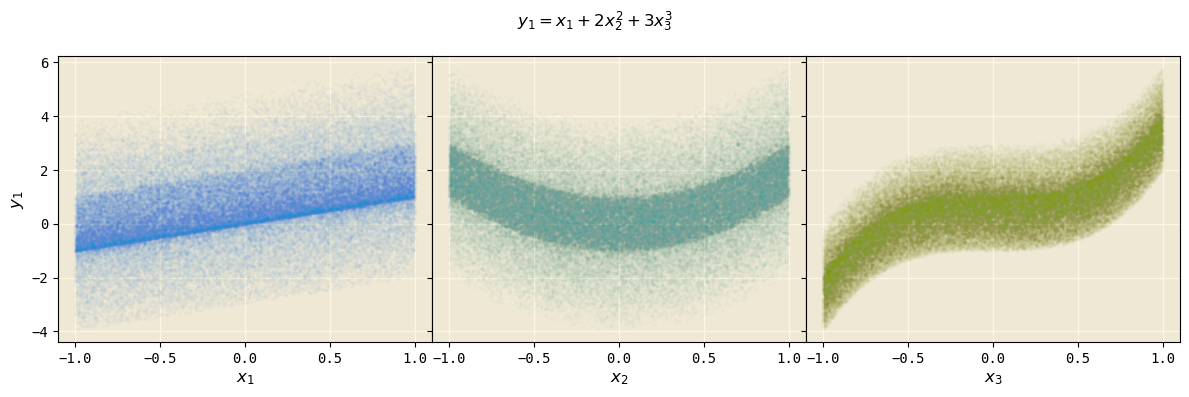

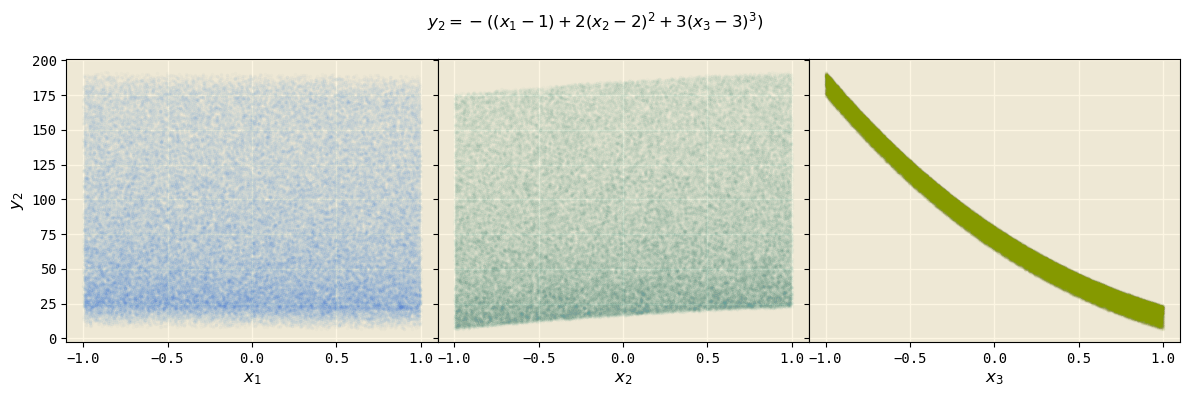

In [3]:
data_N = int(1e5)

x3_range = 1
x3 = generate_data(x3_range, data_N)

x2_range = 1
x2 = generate_data(x2_range, data_N)

x1_range = 1
x1 = generate_data(x1_range, data_N)

y1 = f1(x1, x2, x3)
y2 = f2(x1, x2, x3)

input_plots(x1,x2,x3,y1, ylabel = r'$y_1$', title=r'$y_1 = x_1 + 2x_{2}^2 + 3x_{3}^3$')
input_plots(x1,x2,x3,y2, ylabel = r'$y_2$', title=r'$y_2 = -((x_1 -1) + 2(x_2 - 2)^2 + 3(x_3 -3)^3)$')

Funky! But bold of use to assume that our inputs would even have a remotely similar dynamic range - astrophysics is the field of astronomically large numbers, after all.

Let's see what happens if we add some different orders of magnitude to this example:

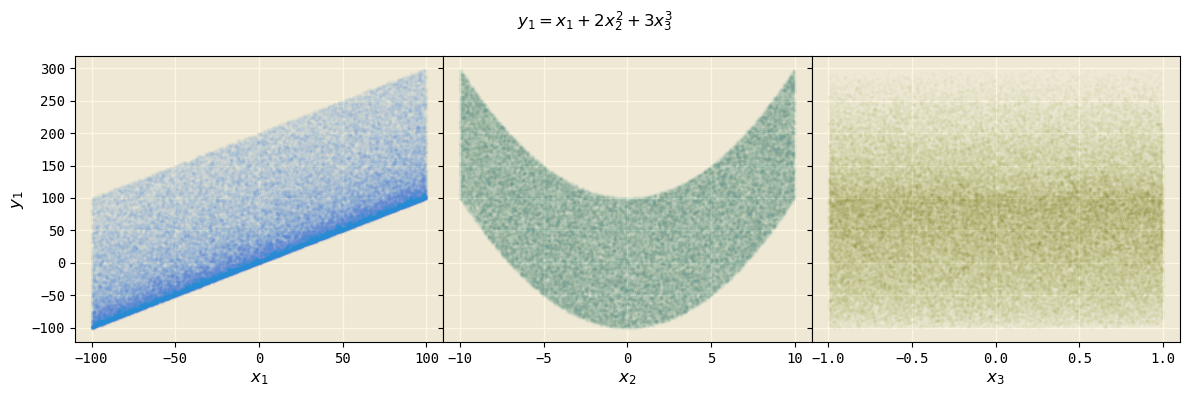

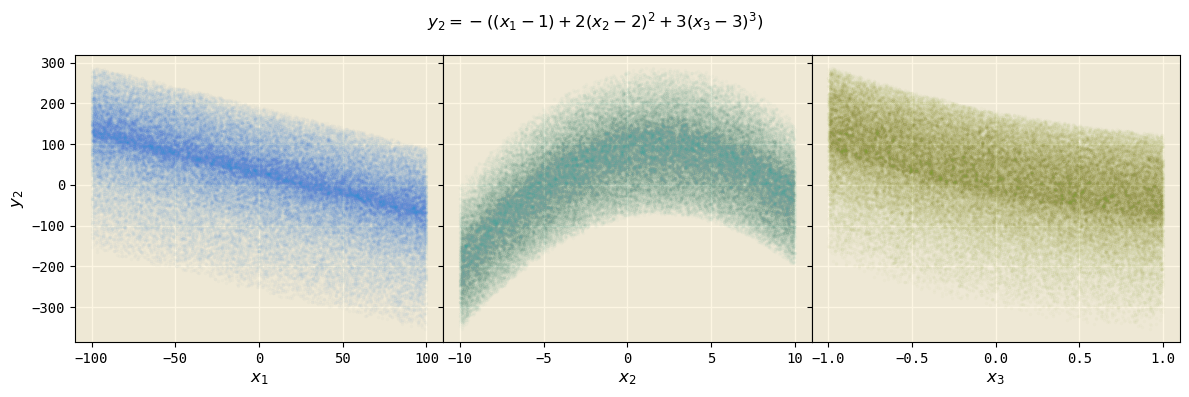

,x1,x2,x3,y1,y2
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.085068,0.015991,0.000164,66.669150,16.464441
std,57.798717,5.769937,0.577960,83.031218,106.203725
min,-99.998732,-9.999873,-0.999993,-101.652533,-353.861308
25%,-50.099116,-4.976189,-0.501405,4.055918,-50.767429
50%,0.037999,-0.000764,-0.001429,65.129790,23.122906
75%,50.224707,5.008864,0.500374,121.306278,92.084597
max,99.999458,9.999997,0.999957,297.922438,287.048483


In [4]:
data_N = int(1e5)

x3_range = 1
x3 = generate_data(x3_range, data_N)

x2_range = 10
x2 = generate_data(x2_range, data_N)

x1_range = 100
x1 = generate_data(x1_range, data_N)

y1 = f1(x1, x2, x3)
y2 = f2(x1, x2, x3)

input_plots(x1,x2,x3,y1, ylabel = r'$y_1$', title=r'$y_1 = x_1 + 2x_{2}^2 + 3x_{3}^3$')
input_plots(x1,x2,x3,y2, ylabel = r'$y_2$', title=r'$y_2 = -((x_1 -1) + 2(x_2 - 2)^2 + 3(x_3 -3)^3)$')

df = pd.DataFrame({
    "x1" : x1,
    "x2" : x2,
    "x3" : x3,
    "y1" : y1,
    "y2" : y2
})

df.describe()

We'll avoid going into too much detail here, but the way that neural networks adapt the neuron weights and biases during training means that a feature with comparitively large dynamic range (in this case, $x_1$) can lead to bizarre behaviour in our training - typically with weights becoming either very large or very small (look up exploding/vanishing gradients if you're interested).

An easy way around this is to scale our data using some easily reversible transformation prior to training.

Often this is only applied to the input data, but I have never seen a reason to *not* scale the outputs too - I reckon this can help prevent overflow errors with stupidly large predictions, if for instance the network is trying to predict outputs with a large dynamic range.

There are a few choices for this, but typically we'd choose either ***normalisation*** or ***standardisation***.

### normalisation
normalisation is the most common choice for when our variables are not normally distributed (like the dummy data we're using here, which is uniformly distributed).\
to normalise our data, we scale our parameters to all lie in the range $[0,1]$ (or sometimes $[-1,1]$) using the transformation

$x_i' = \frac{x_i-\text{min}(x_i)}{\text{max}(x_i)-\text{min}(x_i)}$

as follows:


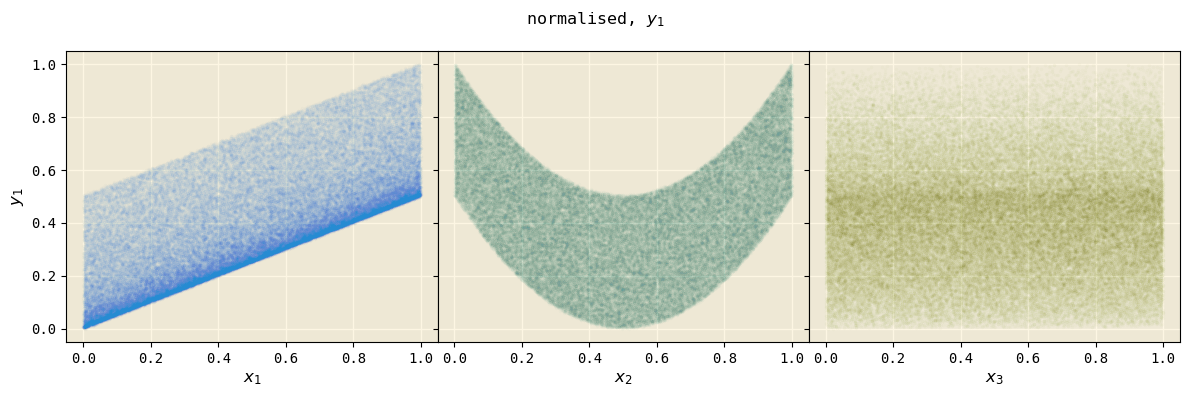

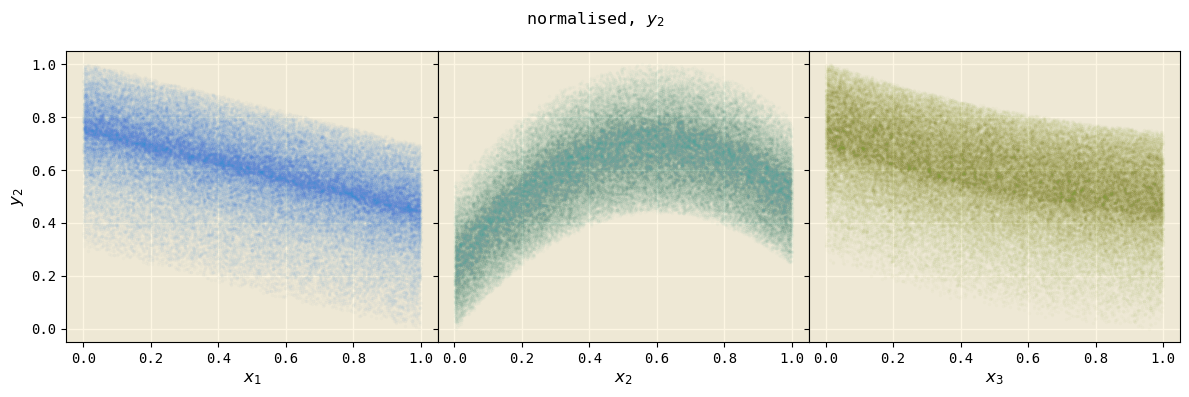

,x1_norm,x2_norm,x3_norm,y1_norm,y2_norm
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500424,0.500796,0.500091,0.421252,0.577813
std,0.288996,0.288499,0.288987,0.207799,0.165708
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.249500,0.251186,0.249300,0.264552,0.472912
50%,0.500188,0.499959,0.499294,0.417399,0.588202
75%,0.751124,0.750442,0.750202,0.557990,0.695801
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
def normalise(df, column):
    values = df[column].values
    values_min = np.min(values)
    values_max = np.max(values)

    values_norm = (values - values_min)/(values_max - values_min)
    
    df[f"{column}_norm"] = values_norm

input_columns = ["x1", "x2", "x3"]
output_columns = ["y1","y2"]
columns = input_columns+output_columns

for column in columns:
    normalise(df,column)

input_plots(df["x1_norm"],df["x2_norm"],df["x3_norm"],df["y1_norm"], ylabel = r'$y_1$', title=r'normalised, $y_1$')
input_plots(df["x1_norm"],df["x2_norm"],df["x3_norm"],df["y2_norm"], ylabel = r'$y_2$', title=r'normalised, $y_2$')

df[[f"{column}_norm" for column in columns]].describe()

As we can see, these are all scaled nicely between 0 and 1 now, which should make things a lot easier for our network during training.

So long as we save the $\text{min}(x_i)$ and $\text{max}(x_i)$ values used to normalise, this is fully reversible:

$x_i = x_i'(\text{max}(x_i)-\text{min}(x_i)) + \text{min}(x_i)$

### standardisation

Another approach is standardisation, which is usually chosen when our dataset contains data that is close to normally distributed.
To standardise, we apply the transformation:

$x_i' = \frac{x_i - \bar{x_i}}{\sigma_{x_i}}$,

where $\bar{x_i}$ is the mean of the feature and $\sigma_{x_i}$ is the standard deviation.

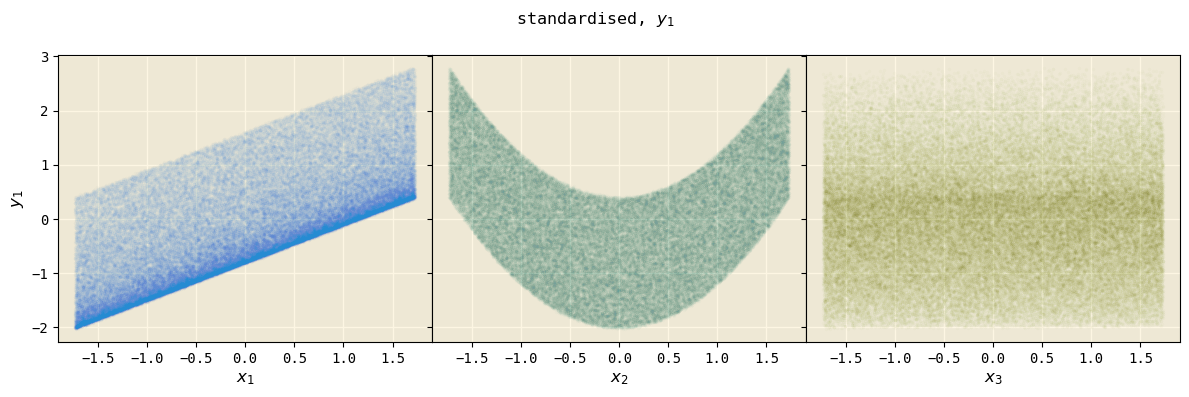

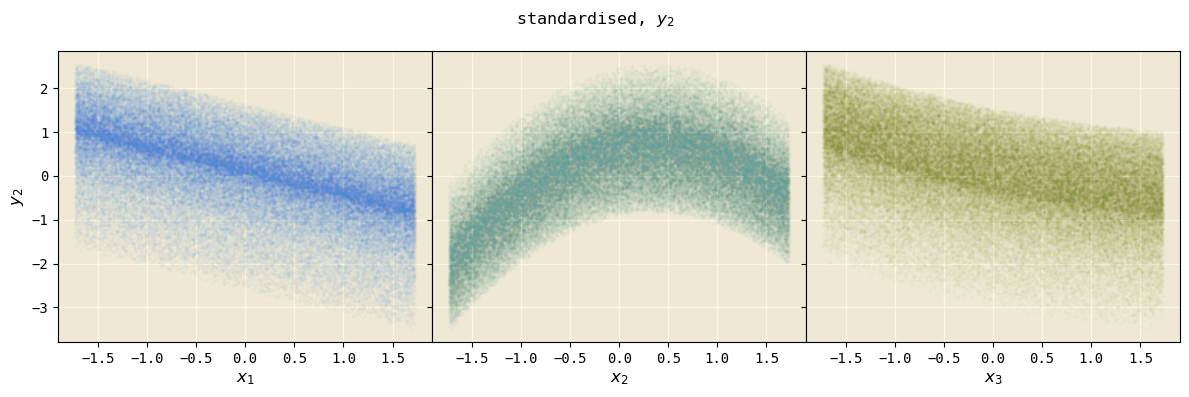

,x1_std,x2_std,x3_std,y1_std,y2_std
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,-4.359180e-17,-4.142464e-17,2.078338e-18,-1.267608e-16,-3.979039e-18
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.731601e+00,-1.735879e+00,-1.730502e+00,-2.027220e+00,-3.486955e+00
25%,-8.682621e-01,-8.652096e-01,-8.678301e-01,-7.540964e-01,-6.330494e-01
50%,-8.143619e-04,-2.903976e-03,-2.756155e-03,-1.853962e-02,6.269553e-02
75%,8.674914e-01,8.653296e-01,8.654783e-01,6.580344e-01,7.120328e-01
max,1.728670e+00,1.730358e+00,1.729873e+00,2.785151e+00,2.547796e+00


In [6]:
def standardise(df, column):
    values = df[column].values
    values_mean = np.mean(values)
    values_std = np.std(values)

    values_std = (values - values_mean)/(values_std)
    
    df[f"{column}_std"] = values_std

input_columns = ["x1", "x2", "x3"]
output_columns = ["y1","y2"]
columns = input_columns+output_columns

for column in columns:
    standardise(df,column)

input_plots(df["x1_std"],df["x2_std"],df["x3_std"],df["y1_std"], ylabel = r'$y_1$', title=r'standardised, $y_1$')
input_plots(df["x1_std"],df["x2_std"],df["x3_std"],df["y2_std"], ylabel = r'$y_2$', title=r'standardised, $y_2$')

df[[f"{column}_std" for column in columns]].describe()

Again, this is absolutely reversible so long as we keep hold of the $\bar{x_i}$ and $\sigma_{x_i}$ used to scale the data:

$x_i = (\sigma_{x_i} \times x_i') + \bar{x_i}$

## gridsearch dataframe
As we know, neural networks are highly customisable in their architecture and hyperparameters.

Often, we're trying to find the best trade-off between a network that is complex enough to precisely approximate the functions we want it to learn, but not so complex that we begin to overfit to the training set (and become computationally slow to compute).

To find the "optimal" network, a typical procedure is a ***gridsearch*** routine.

Gridsearching involves populating a grid with potential network architecture and hyperparameter combinations that we want to try, and training each for a set number of epochs.

Once we've trained a network with each of our unique architecture combinations, we can compare the final loss score of each and see which one performed the best without overfitting.

Let's decide some basic architecture and hyperparameter choices for a network to train on our dataset, and populate a dataframe using `itertools.product`:

In [7]:
n_layers = [2,4,6]
n_neurons = [8,16,32]
activation = ['elu', 'relu']

architectures_df = pd.DataFrame(product(n_layers, n_neurons, activation), columns = ["n_layers", "n_neurons", "activation"])
architectures_df

,"n_layax.axline((0, 0), slope=1)ers",n_neurons,activation
0,2,8,elu
1,2,8,relu
2,2,16,elu
3,2,16,relu
4,2,32,elu
5,2,32,relu
6,4,8,elu
7,4,8,relu
8,4,16,elu
9,4,16,relu


If each of the rows in this `architectures_df` dataframe is a unique combination of neural network architectures, then it's not hard to see how this can scale up very quickly ($N = \Pi\,\text{len(architecture parameter)}$) if we start to think about more complex architecture scenarios (batch normalisation, dropout fractions, varied neurons per layer, different optimisers... the list goes on!).

We'll come back to this dataframe in the next section, where we'll go over how we can use each row to create, train, and save a network with a different architecture.

I'll show you how get tensorflow to adopt network architectures and hyperparameters based on this dataframe, and hopefully it should make it fairly easy to make your own with more architecutre parameters!

## training loop
Now we have our dataframe of networks to gridsearch over, let's make a training loop so we can set our gridsearch routine going while we go and make a (your beverage of choice here).

First, lets split the dataset we generated and scaled earlier into a training, test, and validation set:

In [8]:
seed = 42

## pull training and validation from df and set aside remainder for test
df_train_val = df.sample(frac=0.9, random_state=seed)
df_test = df.drop(df_train_val.index)

## drop val from from training and validation
df_train = df_train_val.sample(frac=0.9, random_state=seed)
df_val = df_train_val.drop(df_train.index)

Because our data was not normally distributed, we'll use the normalised parameters as inputs and outputs:

In [9]:
inputs = ["x1_norm","x2_norm","x3_norm"]
outputs = ["y1_norm", "y2_norm"]

Now it's time to set up our training loop! We'll use the tensorflow functional API for the following.

Notice below that I define an `nn_name` variable that will be unique for each network based on the architecture, and is vaguely informative at first glance (`{n_layers}l_{n_neurons}n_{activation}` tells us how many layers and units we have). This prevents networks from overwriting one another, and means we can tell what archicture a network has just on a glance at the saved file. I'm sure there are much neater ways of doing this, or maybe specific naming conventions, but even this rough method will save us a headache later on!

There's going to be a few lines here that need explaining, so I'll try to leave comments as I go:


In [10]:
tf.keras.backend.clear_session() #garbage collect of previous tensorflow models that might be hogging memory
log_dir = "./logs/fit/"
model_dir = "./models/"

for architecture_idx, architecture in architectures_df.iterrows():
    tf.keras.backend.clear_session()
    ######## input
    nn_input = keras.Input(shape=(len(inputs),)) #input always has shape = len(inputs)

    ######## dense layers
    ## unpack architecture parameters
    n_layers = int(architecture["n_layers"]) #n_layers, assure int
    n_neurons = int(architecture["n_neurons"]) #n_neurons, and assure int
    activation = architecture["activation"]

    ## loop to populate with dense layers
    for layer_idx in range(n_layers):
        if layer_idx == 0: #check if first layer
            nn_d_layer = layers.Dense(n_neurons, activation=activation)(nn_input)
        else:
            nn_d_layer = layers.Dense(n_neurons, activation=activation)(nn_d_layer)

    ######## output
    nn_output = layers.Dense(len(outputs), activation="linear")(nn_d_layer)

    ######## construct and name
    nn_name = f"{n_layers}l_{n_neurons}n_{activation}"
    nn_model = keras.Model(inputs=nn_input, outputs=nn_output, name=nn_name)

    ######## define optimiser and compile
    optimiser = tf.keras.optimizers.Adam(learning_rate = 0.001) # consider gridsearching over opt and lr too!
    
    # it's important to keep loss the same across the gridsearch if you want to benchmark architectures!!
    nn_model.compile(loss="MSE", optimizer=optimiser)

    ######## define callbacks
    # callbacks are functions that are continuously called during training

    ## checkpointing callback
    # used to save the model when validation loss decreases
    # means we don't lose a model if it overfits

    cp_callback = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}{nn_name}.keras",
                                                    monitor="val_loss", #metric to monitor 
                                                    save_best_only=True, #only save if metric improves
                                                    save_freq="epoch", #how often to save
                                                    ) 
    ## tensorboard_callback
    # these logs can be opened manually, but tensorboard is a nice way to view loss profiles
    # in real time, and view multiple networks at once. great for gridsearch benchmarking!

    # tensorboard is launched by opening a terminal window in the parent directory, and
    # then run: `tensorboard --logdir=logs/fit`
    # then copy the link in the console to a browser 
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=f"{log_dir}{nn_name}")
    
    
    ######## fit model
    history = nn_model.fit(df_train[inputs],
                    df_train[outputs],
                    validation_data=(df_val[inputs],df_val[outputs]),
                    batch_size=2**10,
                    verbose=2, #0=silent, 1=progress bar, 2=line per epoch
                    epochs=100,
                    callbacks = [cp_callback, tb_callback],
                    shuffle=True
                   )

KeyError: 'n_layers'

Congrats, you're running a neural network gridsearch over a set of different architectures and hyperparameters, and saving the results in a neat(ish) way!

If the above sounds like a brute-force, trial-and-error, stumbling-around-in-the-dark type approach, that's because it is... without domain specific knowledge and prior intuition about what complexity we might need beforehand, it can be difficult to know what type of network will perform well before we start training.

There are other options for a more informed gridsearch approach that use the returned loss scores to constrain the optimal parameters and inform where to search next, but I haven't implemented these yet.

This is the time consuming part of making neural network emulators, especially if you have high standards for the final network's precision - I hope you like watching loss scores decrease and progress bars fill up!

## evaluating gridsearch networks
By looking at the gridsearch loss profiles in tensorboard, we can see which network architecture seems to be performing well for our dataset.

Your success may vary (due to the random nature of how weights and biases are initialised when we start training), but for me at least the best performing network was `4l_8n_elu`- if we hadn't been careful about naming, we'd have to load back in the model and check manually what the architecture was!

This is what my tensorboard loss profiles look like (yours may vary):
<img src="./figs/tensorboard_profiles.png" width="1500" height="800">

Now let's try and load this network back in and check the results on our test set.

We need to remember to rescale the outputs from the network, as they'll be in normalised space! Luckily, we have our unscaled dataframe from earlier that we can get the relevant rescaling parameters from.

In [98]:
def test_plots(nn_name, df_preds, df_test):
    def centre_axis(ax):
        xabs_max = abs(max(ax.get_xlim(), key=abs))
        ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
    
    ax1.scatter(df_preds["y1"], df_test["y1"], c=colours[3])
    ax1.axline((0, 0), slope=1, c='k', linestyle='--')
    ax1.set_xlabel(r"$\hat{y1}$")
    ax1.set_ylabel(r"$y1$")
    
    ax2.scatter(df_preds["y2"], df_test["y2"], c=colours[4])
    ax2.axline((0, 0), slope=1, c='k', linestyle='--')
    ax2.set_xlabel(r"$\hat{y2}$")
    ax2.set_ylabel(r"$y2$")
    
    y1_residuals = np.array(df_preds["y1"].values-df_test["y1"].values)
    ax3.hist(y1_residuals, color=colours[3], bins=50)
    ax3.axvline(0, c='k', linestyle='--')
    centre_axis(ax3)
    ax3.set_xlabel(r"$\hat{y1} - y1$")
    
    y2_residuals = np.array(df_preds["y2"].values-df_test["y2"].values)
    ax4.hist(y2_residuals, color=colours[4], bins=50)
    ax4.axvline(0, c='k', linestyle='--')
    centre_axis(ax4)
    ax4.set_xlabel(r"$\hat{y2} - y2$")

    plt.suptitle(f"results for {nn_name}", fontsize=20)
    plt.tight_layout()

    print(f"{nn_name} prediction precision:")
    print("---------")
    y1_unc = stats.median_abs_deviation(df_preds["y1"].values-df_test["y1"].values)
    print(f"y1 : {y1_unc}")
    
    y2_unc = stats.median_abs_deviation(df_preds["y2"].values-df_test["y2"].values)
    print(f"y2 : {y2_unc}")

4l_8n_elu prediction precision:
---------
y1 : 0.6011447665563523
y2 : 0.7301105899819369


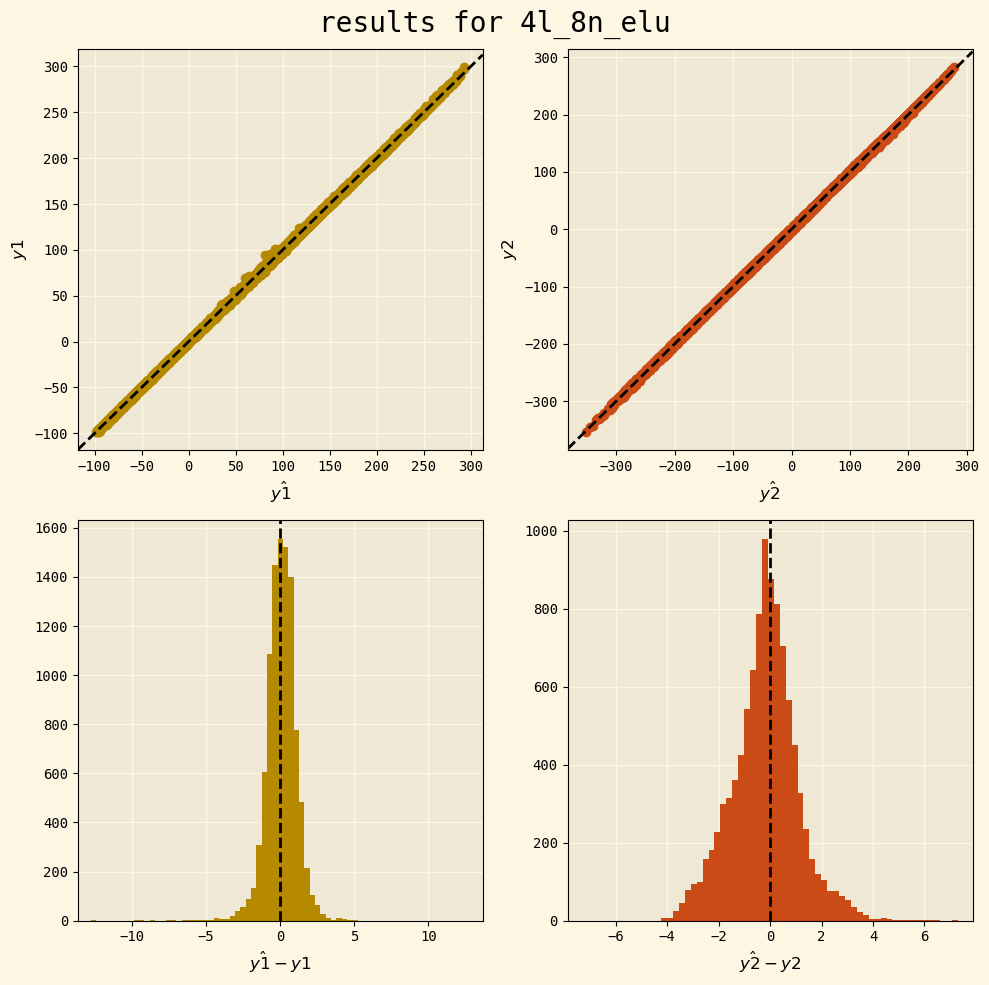

In [96]:
nn_name = "4l_8n_elu"
nn = tf.keras.models.load_model(f"{model_dir}{nn_name}.keras")

## predict
preds_norm = nn(df_test[inputs])

## rescale
preds = (preds_norm*(df[["y1", "y2"]].max() - df[["y1", "y2"]].min())) + df[["y1", "y2"]].min()

## save to df
df_preds = pd.DataFrame(preds, columns=["y1","y2"])

test_plots(nn_name, df_preds, df_test)

Our best performing network looks great! We take the precision as the median absolute deviation of the residual histograms for each output, but there are any number of other ways to parameterise this.

What about our worst network, `2l_8n_relu`? Was it actually much worse?

2l_8n_relu prediction precision:
---------
y1 : 3.9028512757437746
y2 : 4.1674978138808


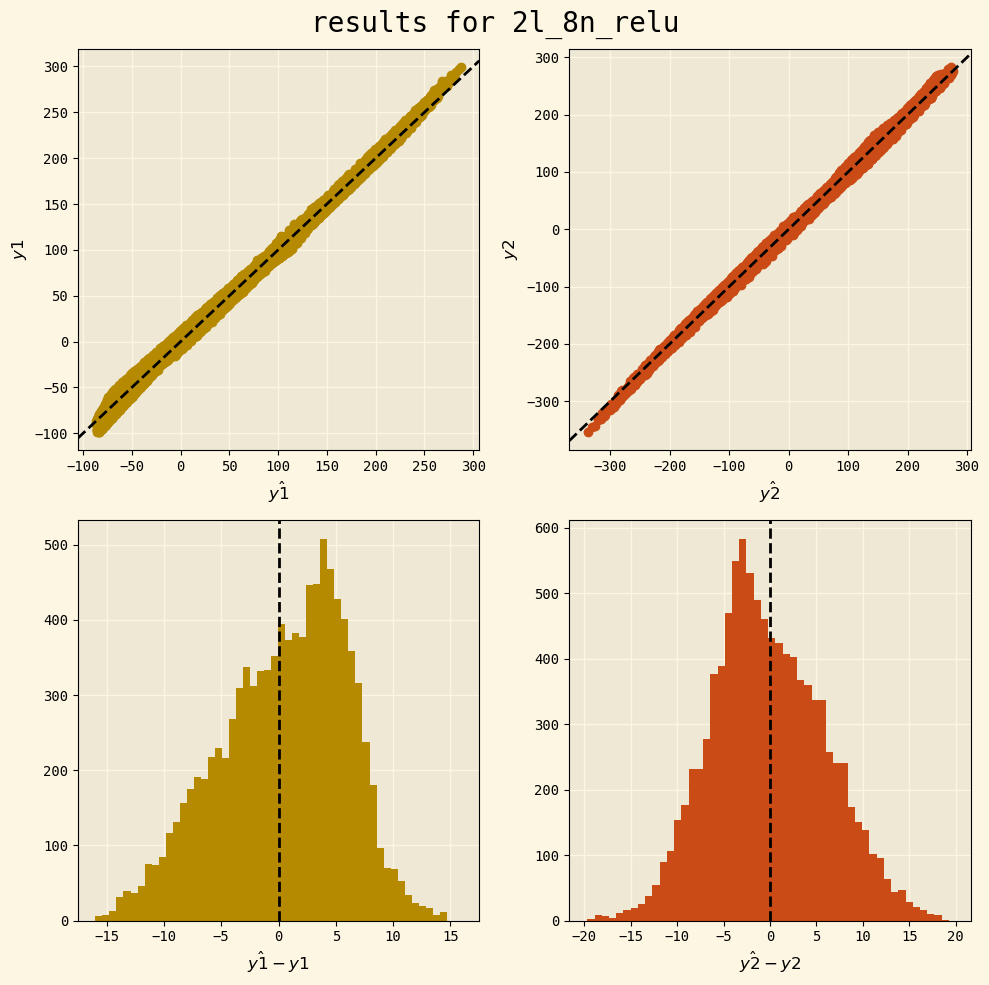

In [99]:
nn_name = "2l_8n_relu"
nn = tf.keras.models.load_model(f"{model_dir}{nn_name}.keras")

## predict
preds_norm = nn(df_test[inputs])

## rescale
preds = (preds_norm*(df[["y1", "y2"]].max() - df[["y1", "y2"]].min())) + df[["y1", "y2"]].min()

## save to df
df_preds = pd.DataFrame(preds, columns=["y1","y2"])

test_plots(nn_name, df_preds, df_test)

Yikes!